In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import pyrosm as pr
from re import sub # For price conversions
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# For calculations
from sklearn import tree
from sklearn.neighbors import BallTree
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LinearRegression

import string
import warnings
warnings.filterwarnings('ignore')

# Clean DataSet

In [2]:
df = pd.read_csv('data/listings.csv')
# print(df.columns)
# Remove unnecessary columns
df = df[['id', 'name', 'description', 'latitude', 'longitude', 'price', 'room_type', 'bedrooms']]
df.rename(columns={'latitude': 'lat', 'longitude': 'lon'}, inplace=True)
df.head()

,id,name,description,lat,lon,price,room_type,bedrooms
0,71609,Ensuite Room (Room 1 & 2) near EXPO,For 3 rooms.Book room 1&2 and room 4<br /><br ...,1.34537,103.95887,"$46,437.00",Private room,2.0
1,71896,B&B Room 1 near Airport & EXPO,<b>The space</b><br />Vocational Stay Deluxe B...,1.34754,103.95958,$81.00,Private room,1.0
2,71903,Room 2-near Airport & EXPO,"Like your own home, 24hrs access.<br /><br /><...",1.34531,103.96100,$81.00,Private room,1.0
3,275343,Amazing Room with window 10min to Redhill,Awesome location and host <br />Room near INSE...,1.29015,103.80814,$52.00,Private room,1.0
4,275344,15 mins to Outram MRT Single Room,Lovely home for the special guest !<br /><br /...,1.28836,103.81144,$49.00,Private room,1.0


### Fix listingDF price `string->int`

In [3]:
print("Before cleaing:", df.price.count(), df.price.dtype)
df['price'] = df.price.map(lambda x: float(sub(r'[^\d.]', '', x)))
print("After cleaning:", df.price.count(), df.price.dtype)

Before cleaing: 3037 object
After cleaning: 3037 float64


### Trim outliers and $0 rental prices

In [4]:
# Remove $0 rental
df = df.query('price != 0')
# Remove outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR)))]
df['price'].describe()

count    2772.000000
mean      179.460317
std       132.364542
min        13.000000
25%        70.000000
50%       146.000000
75%       244.250000
max       629.000000
Name: price, dtype: float64

Filter out rooms with more than 1 bed.

# Feature Engineering

Let new_price = price / bedrooms (accounting for shared rental)

private room:
    - 1 person room is much more valuable
    - 2 people room is slightly more valuable
    - 3+ people room grows linearly 

entire house:
    - 1 person house is much more valuable
    - 2+ people house is less valuable 

Private room       1384
Entire home/apt    1152
Hotel room          121
Shared room         115
Name: room_type, dtype: int64

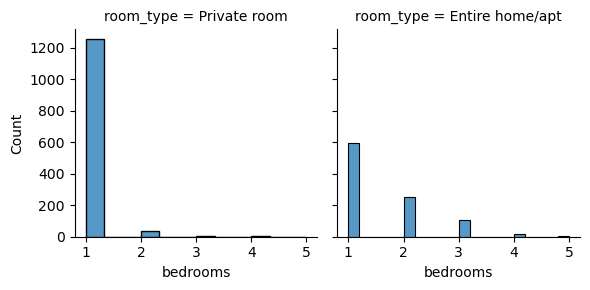

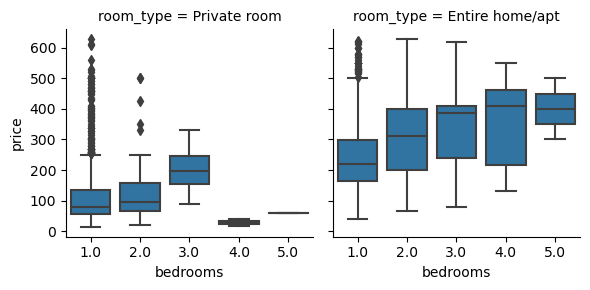

In [5]:
display(df['room_type'].value_counts())
# Discard hotel room and shared room
df = df[df['room_type'] != 'Shared room']
df = df[df['room_type'] != 'Hotel room']
# Plot against different number of bedrooms
# First, number of each type of bedrooms
g = sns.FacetGrid(df, col='room_type')
g.map(sns.histplot, 'bedrooms')
# Then, price range of each type of bedrooms
g = sns.FacetGrid(df, col='room_type')
g.map(sns.boxplot, 'bedrooms', 'price')

Hence, we can delete all private room listing with more than one bedrooms.

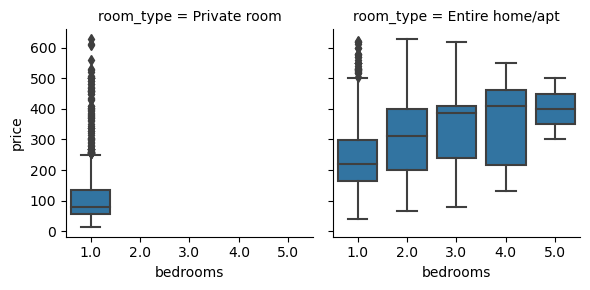

In [6]:
df = df.drop(df[(df['room_type'] == 'Private room') & (df['bedrooms'] > 1)].index)
g = sns.FacetGrid(df, col='room_type')
g.map(sns.boxplot, 'bedrooms', 'price')

### Visualisation

<Axes: xlabel='price', ylabel='Count'>

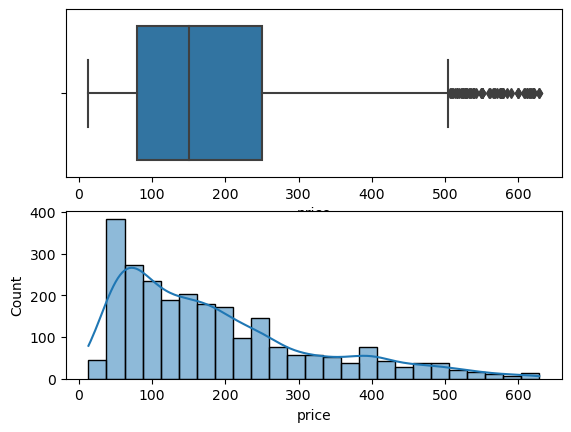

In [7]:
fig, (ax1, ax2) = plt.subplots(2)
sns.boxplot(ax=ax1, x=df['price'], orient='h')
sns.histplot(ax=ax2, data=df, x='price', kde=True)

We can see that AirBNB price per night is $180+-132.

# Using Classification Tree

<Axes: xlabel='price', ylabel='Count'>

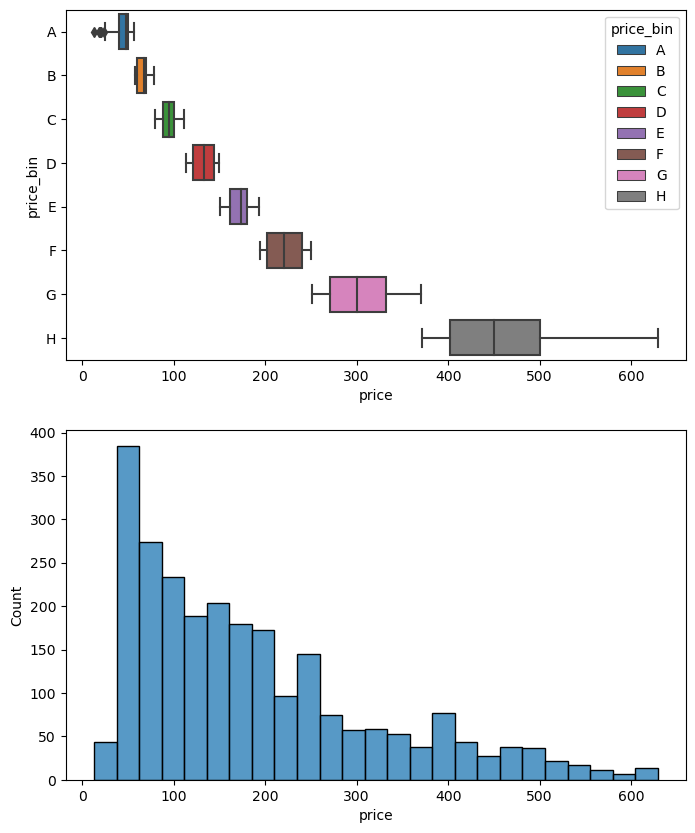

In [8]:
MAX_BINS = 8
bin_lbls = list(string.ascii_uppercase)[:MAX_BINS]
df['price_bin'] = pd.qcut(df['price'], q=MAX_BINS, labels=bin_lbls)

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,10))
sns.boxplot(ax=ax1, data=df, x='price', y='price_bin', hue='price_bin', dodge=False)
sns.histplot(ax=ax2, data=df, x='price')

Score: 0.30861723446893785


<Axes: >

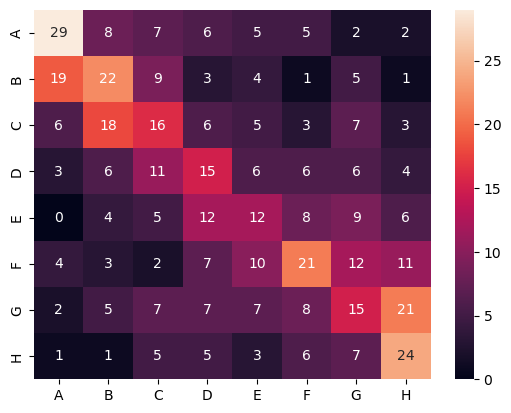

In [9]:
X = pd.concat([df.lat, df.lon], axis=1)
y = df.price_bin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print("Score:", clf.score(X=X_test, y=y_test))

C = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(C, xticklabels=bin_lbls, yticklabels=bin_lbls, annot=True)

# Using K-Nearest Neighbours (Ball Tree)

In [10]:
city = pr.OSM('data/singapore.pbf')
city.get_pois()

custom_filter = {
    'amenity': ["restaurant", "food_court"], # Food court 
    'leisure': ["school"], # School
    'public_transport': ['station', 'platform'], # MRT and Bus stop respectively
    'shop': ["mall"] # Shopping mall
}
# Read POIs with custom filter
pois: gpd.GeoDataFrame = city.get_pois(custom_filter=custom_filter)
pois = pois[['id', 'lon', 'lat', 'tags', 'leisure', 'shop', 'amenity', 'public_transport', 'geometry', 'osm_type']]
pois.dropna(subset=['lon', 'lat'], inplace=True)
pois.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 8665 entries, 0 to 8664
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                8665 non-null   int64   
 1   lon               8665 non-null   float32 
 2   lat               8665 non-null   float32 
 3   tags              7204 non-null   object  
 4   leisure           2 non-null      object  
 5   shop              26 non-null     object  
 6   amenity           4331 non-null   object  
 7   public_transport  4383 non-null   object  
 8   geometry          8665 non-null   geometry
 9   osm_type          8665 non-null   object  
dtypes: float32(2), geometry(1), int64(1), object(6)
memory usage: 677.0+ KB


In [11]:
# Creates new columns converting coordinate degrees to radians.
def degree_to_radians(locationA):
    for column in locationA[["lat", "lon"]]:
        rad = np.deg2rad(locationA[column].values)
        locationA[f'{column}_rad'] = rad

mrt_pois = pois[pois['public_transport'] == 'station']

# Convert the two datasets to radians
degree_to_radians(mrt_pois)
degree_to_radians(df)

# Builds geometry shape for each amenity
bT = BallTree(mrt_pois[['lat_rad', 'lon_rad']].values, metric='haversine')

distances, _ = bT.query(df[['lat_rad', 'lon_rad']].values, k=1)

In [12]:
distances = np.squeeze(distances)
convert_to_km = np.vectorize(lambda x: x * 6371) # Convert to km
distances = convert_to_km(distances)
distances = pd.Series(distances, name='distance_from_MRT')
distances

0       0.843170
1       0.880536
2       0.199266
3       0.245713
4       0.293899
          ...   
2490    1.425344
2491    0.689583
2492    1.211829
2493    0.895367
2494    0.636995
Name: distance_from_MRT, Length: 2495, dtype: float64

In [13]:
# Append distance from MRT to house
df.reset_index(drop=True, inplace=True)
distances.reset_index(drop=True, inplace=True) 
df = pd.concat([df, distances], axis=1)
df.head()

,id,name,description,lat,lon,price,room_type,bedrooms,price_bin,lat_rad,lon_rad,distance_from_MRT
0,71896,B&B Room 1 near Airport & EXPO,<b>The space</b><br />Vocational Stay Deluxe B...,1.34754,103.95958,81.0,Private room,1.0,C,0.023519,1.814437,0.843170
1,71903,Room 2-near Airport & EXPO,"Like your own home, 24hrs access.<br /><br /><...",1.34531,103.96100,81.0,Private room,1.0,C,0.023480,1.814462,0.880536
2,275343,Amazing Room with window 10min to Redhill,Awesome location and host <br />Room near INSE...,1.29015,103.80814,52.0,Private room,1.0,A,0.022517,1.811794,0.199266
3,275344,15 mins to Outram MRT Single Room,Lovely home for the special guest !<br /><br /...,1.28836,103.81144,49.0,Private room,1.0,A,0.022486,1.811851,0.245713
4,294281,5 mins walk from Newton subway,I have 3 bedrooms in a charming British style...,1.31142,103.83924,79.0,Private room,1.0,B,0.022889,1.812337,0.293899


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 2495 non-null   int64   
 1   name               2495 non-null   object  
 2   description        2453 non-null   object  
 3   lat                2495 non-null   float64 
 4   lon                2495 non-null   float64 
 5   price              2495 non-null   float64 
 6   room_type          2495 non-null   object  
 7   bedrooms           2224 non-null   float64 
 8   price_bin          2495 non-null   category
 9   lat_rad            2495 non-null   float64 
 10  lon_rad            2495 non-null   float64 
 11  distance_from_MRT  2495 non-null   float64 
dtypes: category(1), float64(7), int64(1), object(3)
memory usage: 217.3+ KB


### Then we can do linear regression!

Start by visualising the data.

<Axes: xlabel='distance_from_MRT', ylabel='price'>

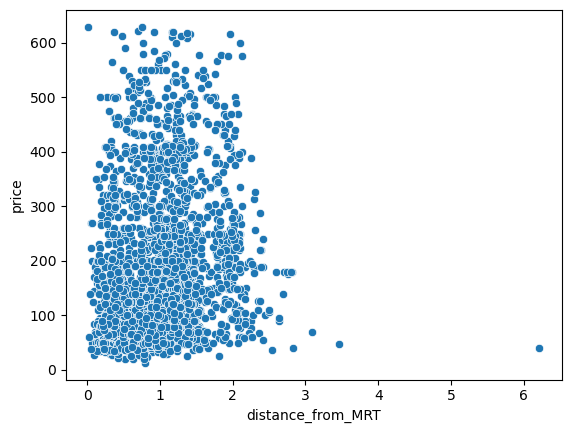

In [15]:
sns.scatterplot(df, x='distance_from_MRT', y='price')

Another variable!